## Project 7
In this project, you will implement the the clustering techniques that you've learned this week.

#### Step 1: Load the python libraries that you will need for this project

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
% matplotlib inline

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning) 

In [ ]:
# from scipy.stats import pearsonr, normaltest
# from sklearn import preprocessing
# from sklearn.decomposition import PCA
# from sklearn import metrics

#### Step 2: Examine your data

In [2]:
# create file path for read_csv

path_air_op = '/Users/michaelshea/desktop/DSI-DC-1/Projects/project-07/assets/Airport_operations.csv'
path_air_canc = '/Users/michaelshea/desktop/DSI-DC-1/Projects/project-07/assets/airport_cancellations.csv'
path_air_info = '/Users/michaelshea/desktop/DSI-DC-1/Projects/project-07/assets/airports.csv'

In [3]:
# read in operations csv

air_op = pd.read_csv(path_air_op)

In [4]:
# read in cancellations csv

air_canc = pd.read_csv(path_air_canc)

In [5]:
# read in info csv

air_info = pd.read_csv(path_air_info)

In [6]:
# Convert air_canc.year to integer dtype

air_canc['Year'] = air_canc['Year'].astype(int)
air_canc['Year'] = air_canc['Year'].astype(str)
air_op['year'] = air_op['year'].astype(str)

In [7]:
# Add ID column to cancellations and operations with concatenated year and id

air_op["air_id"] = air_op["airport"].map(str) + air_op["year"]
air_canc["air_id"] = air_canc["Airport"].map(str) + air_canc["Year"]

In [8]:
# view top two departure cancellations

air_canc.groupby('Airport').mean().sort_values(by='Departure Cancellations', ascending=False).head(2)

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
Airport,,,,
ORD,10892.000000,11730.454545,735.000000,769.090909
ATL,6562.363636,7317.272727,884.454545,872.181818


In [9]:
air_info.head(1)

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes


## Intro: Write a problem statement / aim for this project

Examine unlabeled data using PCA and clustering.

## Part 1: Create a PostgreSQL database

#### 1. Let's create a database where we can house our airport data

In [21]:
from sqlalchemy import create_engine

#### 2. Create tables for our data

In [42]:
# Establish connection

engine = create_engine('postgresql://michaelshea@localhost:5432/project_7')

# Send operations df to SQL

air_op.to_sql('operations', engine, flavor='postgres', if_exists='replace')

In [43]:
# Send cancellations df to SQL

air_canc.to_sql('cancellations', engine, flavor='postgres', if_exists='replace')

In [44]:
# Send info df to SQL

air_info.to_sql('info', engine, flavor='postgres', if_exists='replace')

#### 3. Load our csv files into tables

In [8]:
%load_ext sql

/Users/michaelshea/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/michaelshea/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [9]:
%%sql
postgresql://michaelshea@localhost:5432/project_7

u'Connected: michaelshea@project_7'

#### 4. Merge the Tables

In [50]:
# %sql SELECT * FROM cancellations LIMIT 3;

In [10]:
# merge dataframes operations and cancellations

merged_canc_op = pd.merge(air_op, air_canc, on='air_id')

In [11]:
# need to add new column to air_info for second merge

air_info['airport'] = air_info['LocID']

In [12]:
# second merge: left outer join

merged_all = pd.merge(merged_canc_op, air_info, how='left', on='airport')

In [13]:
# Prove that second merge worked as we wanted

print merged_canc_op.shape
print merged_all.shape

(799, 22)
(799, 35)


#### 5. Query the database for our intial data

In [14]:
# do a groupby

merge_grouped = merged_all.groupby('airport').mean().sort_values(by='percent on-time gate departures', ascending=False)

In [139]:
merge_grouped.head(2)

,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,Latitude,Longitude
airport,,,,,,,,,,,,,,,,,,,,
OGG,30094.454545,29570.363636,0.888100,0.881027,0.864709,7.066364,8.190000,1.236364,7.523636,2.122727,0.818182,3.595455,8.060909,156.090909,125.818182,26.272727,24.636364,976.0,20.898650,-156.430458
HNL,91753.363636,92935.545455,0.876409,0.859873,0.849836,8.035455,12.859091,1.842727,8.940000,2.183636,1.219091,3.615455,9.087273,308.636364,305.909091,46.272727,57.727273,975.0,21.318681,-157.922429


#### 6. What are the risks and assumptions of our data?

Risks: 

Assumptions:

## Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [16]:
import seaborn as sns

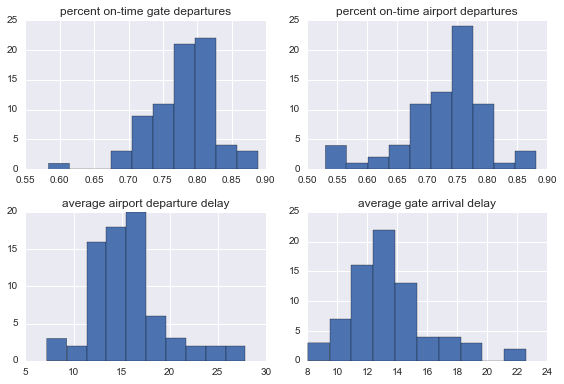

In [17]:
# create a few histograms to describe the data

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flat


ax0.hist(merge_grouped['percent on-time gate departures'])
ax0.set_title('percent on-time gate departures')

ax1.hist(merge_grouped['percent on-time airport departures'])
ax1.set_title('percent on-time airport departures')

ax2.hist(merge_grouped['average airport departure delay'])
ax2.set_title('average airport departure delay')

ax3.hist(merge_grouped['average gate arrival delay'])
ax3.set_title('average gate arrival delay')

plt.tight_layout()

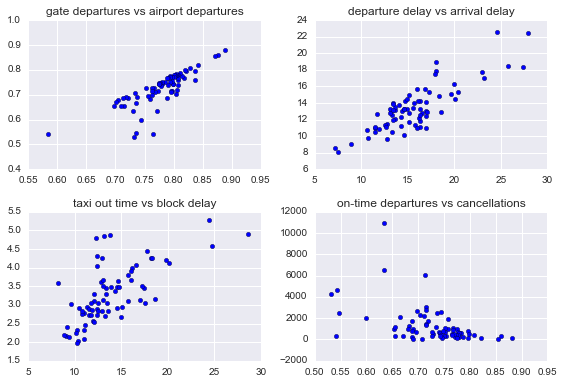

In [18]:
# create a few scatterplots to describe the data

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flat


ax0.scatter(merge_grouped['percent on-time gate departures'], merge_grouped['percent on-time airport departures'])
ax0.set_title('gate departures vs airport departures')

ax1.scatter(merge_grouped['average airport departure delay'], merge_grouped['average gate arrival delay'])
ax1.set_title('departure delay vs arrival delay')

ax2.scatter(merge_grouped['average_taxi_out_time'], merge_grouped['average block delay'])
ax2.set_title('taxi out time vs block delay')

ax3.scatter(merge_grouped['percent on-time airport departures'], merge_grouped['Departure Cancellations'])
ax3.set_title('on-time departures vs cancellations')

plt.tight_layout()

## Part 3: Data Mining

#### Are there any unique values?

In [23]:
pd.DataFrame(merged_all.columns)

,0
0,airport
1,year
2,departures for metric computation
3,arrivals for metric computation
4,percent on-time gate departures
5,percent on-time airport departures
6,percent on-time gate arrivals
7,average_gate_departure_delay
8,average_taxi_out_time
9,average taxi out delay


In [19]:
# Define y before dropping 'airport

y = merged_all.airport.values

In [20]:
# Drop unnecessary columns

merged_all.drop(['airport', 'air_id', 'Airport', 'Year', 'Key', 'LocID', 'AP_NAME', 'ALIAS', 'Facility Type', 
                 'CITY', 'COUNTY', 'Latitude', 'Longitude', 'Boundary Data Available'], axis=1, inplace = True)

In [21]:
# Reconvert year to integer

merged_all['year'] = merged_all['year'].astype(int)

#### 3.1 Create Dummy Variables

In [22]:
merged_all.dtypes

year                                    int64
departures for metric computation       int64
arrivals for metric computation         int64
percent on-time gate departures       float64
percent on-time airport departures    float64
percent on-time gate arrivals         float64
average_gate_departure_delay          float64
average_taxi_out_time                 float64
average taxi out delay                float64
average airport departure delay       float64
average airborne delay                float64
average taxi in delay                 float64
average block delay                   float64
average gate arrival delay            float64
Departure Cancellations               float64
Arrival Cancellations                 float64
Departure Diversions                  float64
Arrival Diversions                    float64
FAA REGION                             object
STATE                                  object
AP Type                                object
dtype: object

In [23]:
# when creating dummies, ensure that drop_first=True so that n-1 dummies are created

final_df = pd.get_dummies(merged_all, drop_first=True)

#### 3.2 Format the data

## Part 4: Refine the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell?

In [24]:
from scipy.stats import pearsonr, normaltest

In [25]:
# counter = 0
# for col in final_df.columns:
#     print col, counter
#     counter += 1

In [26]:
final_df.head(2)

,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,...,STATE_OR,STATE_PA,STATE_PR,STATE_RI,STATE_TN,STATE_TX,STATE_UT,STATE_WA,STATE_WI,AP Type_Public Use
0,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# check whether content in columns 1 through 18 is normally distributed

for i in range(1, 17):
    sample = final_df.iloc[:,i].sample(50)
    print normaltest(sample, nan_policy='omit')[1]

8.66437145094e-07
1.41677943873e-05
0.0184807955792
0.0928604533591
0.0195616594519
0.376513788592
4.08033456805e-12
2.42426467123e-05
1.20664717887e-06
0.0752643731737
4.1962368117e-11
0.154051799395
0.15769233253
3.30566832798e-09
2.0716528477e-21
0.000410360729779


In [ ]:
fig, axes = plt.subplots(17, 1)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17 = axes.flat
plt.tight_layout()

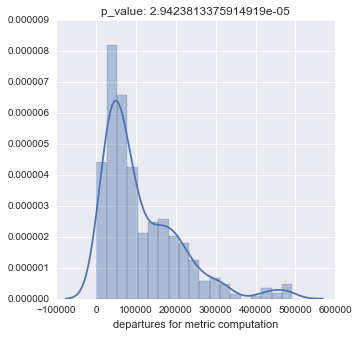

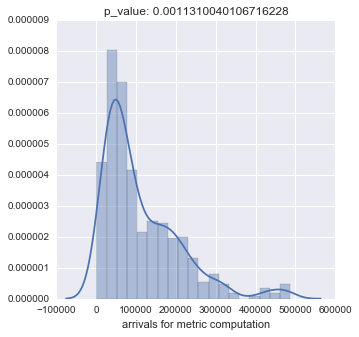

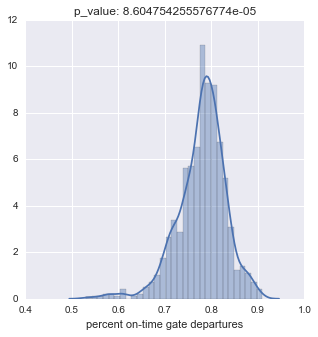

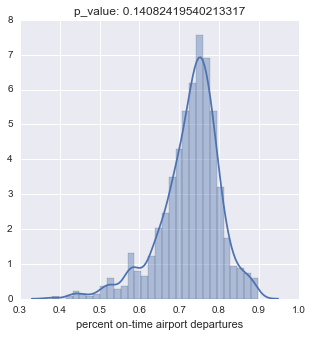

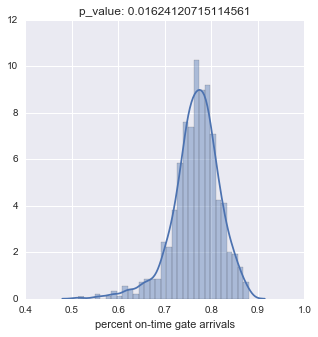

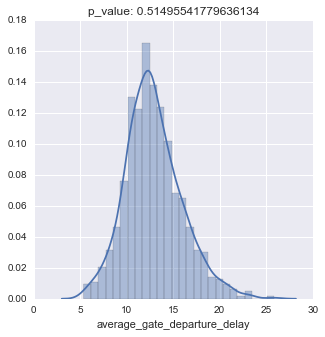

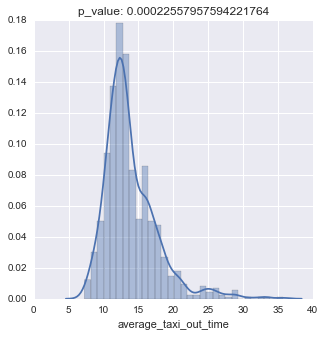

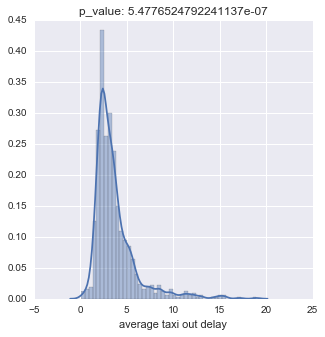

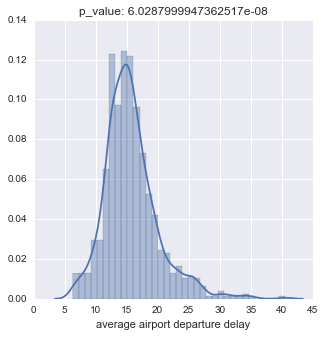

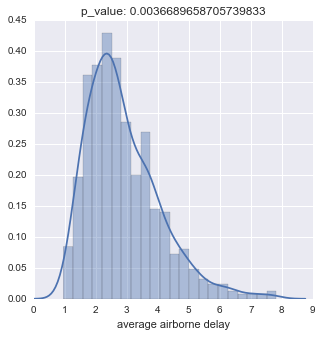

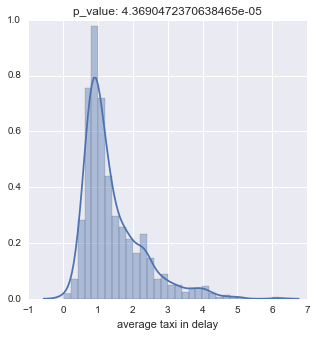

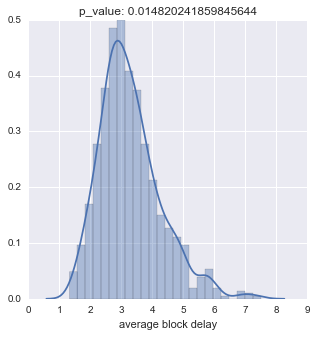

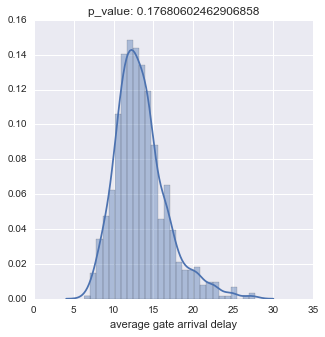

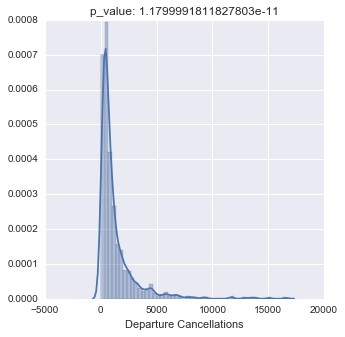

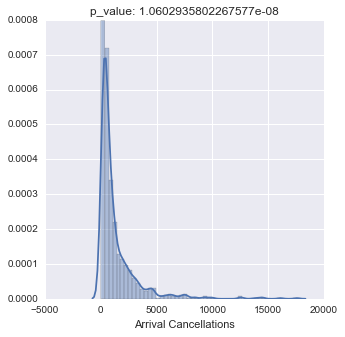

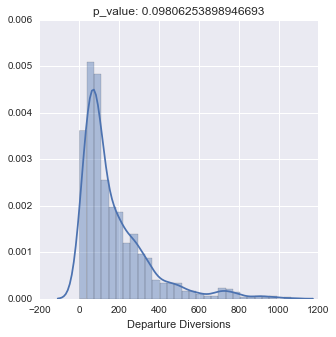

In [70]:
for i in range(1,17):
    sample = final_df.iloc[:,i].sample(50)
    plt.figure(figsize=(5,5))
    sns.distplot(final_df.iloc[:,i])
    #final_df.iloc[:,i].plot.hist() #another plotting method
    plt.title("p_value: %r" % normaltest(sample, nan_policy='omit')[1])

#### 4.2 Find correlations in the data

In [71]:
# Look at correlations in the data

final_df.corr().head()

,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,...,STATE_OR,STATE_PA,STATE_PR,STATE_RI,STATE_TN,STATE_TX,STATE_UT,STATE_WA,STATE_WI,AP Type_Public Use
year,1.000000,-0.068488,-0.067507,0.002818,0.056174,0.135191,0.061650,-0.052435,-0.160599,-0.023332,...,-0.000611,-0.000870,-0.000611,-0.000611,-0.000870,-0.001551,-0.000611,-0.000611,-0.000611,-0.024118
departures for metric computation,-0.068488,1.000000,0.999807,-0.063251,-0.399942,0.103680,0.131396,0.638656,0.604125,0.391838,...,-0.014162,0.066458,-0.078045,-0.101201,-0.004308,0.074869,0.050492,0.057858,-0.053163,-0.020556
arrivals for metric computation,-0.067507,0.999807,1.000000,-0.062713,-0.399040,0.104228,0.129871,0.636674,0.603439,0.390470,...,-0.013813,0.067244,-0.079620,-0.101045,-0.005437,0.075847,0.046285,0.058587,-0.052778,-0.021347
percent on-time gate departures,0.002818,-0.063251,-0.062713,1.000000,0.818598,0.782703,-0.913107,-0.169598,-0.212539,-0.764464,...,0.109894,-0.038619,0.062117,0.014278,-0.107702,-0.097019,0.131974,0.130082,-0.037653,0.168048
percent on-time airport departures,0.056174,-0.399942,-0.399040,0.818598,1.000000,0.695697,-0.826633,-0.653223,-0.725766,-0.954832,...,0.126193,-0.126252,0.079938,0.037189,-0.059309,-0.027328,0.047240,0.107971,-0.001136,0.120167


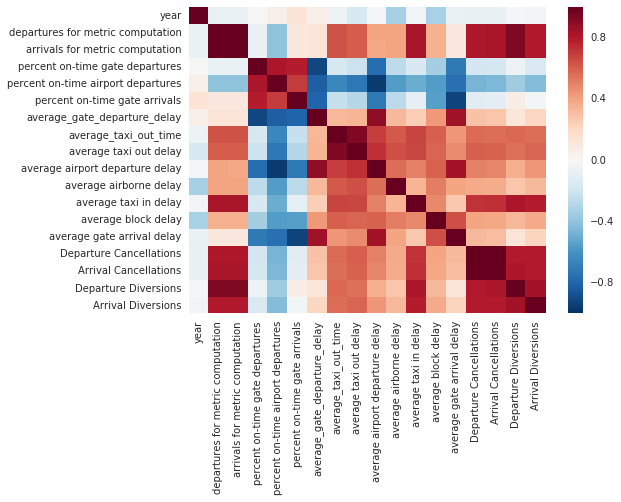

In [27]:
# View heatmap to visualize correlations in the data

sns.heatmap(merged_all.corr())

#### 4.3 What is the p-value? What does this mean?

The p-value in the context of scipy.normaltest represents the following: the probability of finding the observed curtosis and skew of a distribution if the null hypothesis is true. 

The null hypothesis in this context is: the distribution is normally distributed. Thus, a high p-value would lead you to accept the null hypothesis, leading to the conclusion that the distribution __*is normally distributed*__. A low p-value would mean that you reject the null hypothesis, and lead to the conclusion that the distribution is not normally distributed.

#### 4.4 What is the value of understanding correlations before PCA?¶

You want to understand correlations before conducting PCA because it helps you identify whether doing PCA will be valuable in the first place. The goal of PCA is to find the directions of maximum variance -- if covariance between two variables is high, that may be a direction to concentrate on in PCA.

## Part 5: Perform a PCA and Present Findings

#### 5.1 Define your "X" and "Y" variables

In [ ]:
# this was done above

# y = merged_all.airport
# x = final_df

#### 5.2 Standardize the x values

In [100]:
# I assume by this they mean scale the data

from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(final_df)

#### 5.3 Create the covariance matrix

In [101]:
# Covariance is closely related to correlation

covMat = np.cov(X_scaled.T)

#### Check the Eigenvalues and Eigenvectors

In [102]:
# use numpy's linalg tool to calculate eigenvalues and eigenvectors from the covariance matrix

eigenValues, eigenVectors = np.linalg.eig(covMat)

In [103]:
print(eigenValues)

[  9.97921963e+00 +0.00000000e+00j   5.09428997e+00 +0.00000000e+00j
   2.54572760e+00 +0.00000000e+00j   2.37965753e+00 +0.00000000e+00j
   2.26555684e+00 +0.00000000e+00j   2.22355127e+00 +0.00000000e+00j
   2.16411923e+00 +0.00000000e+00j   2.03194756e+00 +0.00000000e+00j
   1.86452660e+00 +0.00000000e+00j   1.53480256e+00 +0.00000000e+00j
   1.46593639e+00 +0.00000000e+00j   1.24215904e+00 +0.00000000e+00j
   1.20967627e+00 +0.00000000e+00j   6.31765098e-01 +0.00000000e+00j
   6.86098803e-01 +0.00000000e+00j   4.48174855e-01 +0.00000000e+00j
   3.11510252e-01 +0.00000000e+00j   2.93124315e-01 +0.00000000e+00j
   2.27136442e-01 +0.00000000e+00j   1.88544726e-01 +0.00000000e+00j
   1.53499748e-01 +0.00000000e+00j   1.20987233e-01 +0.00000000e+00j
   1.04893893e-01 +0.00000000e+00j   8.74908159e-02 +0.00000000e+00j
   4.87428464e-02 +0.00000000e+00j   3.37819142e-02 +0.00000000e+00j
   1.53669983e-02 +0.00000000e+00j   7.78662451e-03 +0.00000000e+00j
   3.41188461e-03 +0.00000000e+00j

In [77]:
print(eigenVectors)

[[  3.62608044e-02 +0.00000000e+00j   3.45052120e-03 +0.00000000e+00j
   -7.41183112e-02 +0.00000000e+00j ...,  -1.82593821e-15 +0.00000000e+00j
    3.06854297e-15 -5.11446304e-16j   3.06854297e-15 +5.11446304e-16j]
 [ -2.37318359e-01 +0.00000000e+00j   2.68324423e-01 +0.00000000e+00j
   -1.93832505e-02 +0.00000000e+00j ...,   3.52076239e-13 +0.00000000e+00j
    5.67002632e-14 -2.20388687e-13j   5.67002632e-14 +2.20388687e-13j]
 [ -2.37002132e-01 +0.00000000e+00j   2.68769007e-01 +0.00000000e+00j
   -1.89949797e-02 +0.00000000e+00j ...,  -3.58599940e-13 +0.00000000e+00j
   -5.14899993e-14 +2.21501794e-13j  -5.14899993e-14 -2.21501794e-13j]
 ..., 
 [  1.34862343e-02 +0.00000000e+00j   6.85031615e-02 +0.00000000e+00j
    9.34434769e-02 +0.00000000e+00j ...,   9.83542053e-02 +0.00000000e+00j
   -6.12645020e-02 -4.74468345e-02j  -6.12645020e-02 +4.74468345e-02j]
 [  5.80423962e-03 +0.00000000e+00j  -2.96371793e-02 +0.00000000e+00j
   -1.74329988e-02 +0.00000000e+00j ...,   1.50538197e-01 +

#### 5.4 Print the Eigenpairs

In [78]:
print len(eigenValues)
print len(eigenVectors)

62
62


In [86]:
# zip together the pairings

pairings = np.abs(zip(eigenVectors, eigenValues))

In [93]:
# print just the eigen value for each pairing

for i in pairings:
    print(i[1])

9.97921963372
5.09428997444
2.54572760137
2.37965753054
2.26555684329
2.22355127474
2.16411923371
2.03194756136
1.86452659838
1.53480255626
1.46593638846
1.24215904039
1.20967627147
0.631765097936
0.686098802755
0.448174854524
0.311510252045
0.293124315474
0.227136442043
0.188544726019
0.153499748367
0.120987233375
0.104893892948
0.0874908159145
0.0487428464382
0.0337819142213
0.0153669983394
0.00778662450678
0.00341188461011
0.00104305773529
0.000826808365015
0.000130087412356
1.10059978754
1.08363026874
1.06359091475
1.0544140989
1.04021069136
1.03723156221
1.03682139843
1.02942144012
1.02688760791
1.02537523531
1.02362764781
1.02195374555
1.01414431673
1.02001476202
1.01941764256
1.01860396285
1.01781048629
1.01685506075
1.01530030667
1.01539224665
1.01545973511
1.01544440617
8.65350508233e-15
3.36281457601e-15
1.97144178042e-15
2.0728267435e-16
1.282188891e-15
7.14577911344e-16
6.01034589031e-16
6.01034589031e-16


#### 5.5 Calculate the explained variance

In [94]:
# Calculate the explained variance - each value represents the percentage of total variance
# that is explained by that component

totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [97]:
# The cumulative sum variance explains how subsequent components add to explain more of the variance 

cvarex = np.cumsum(varExpl)

In [99]:
# Here the first twenty compenents explain 70% of the variance

print cvarex[:20]

[ 16.07537096+0.j  24.28168410+0.j  28.38255742+0.j  32.21591102+0.j
  35.86546159+0.j  39.44734604+0.j  42.93349233+0.j  46.20672531+0.j
  49.21026244+0.j  51.68265220+0.j  54.04410652+0.j  56.04508135+0.j
  57.99373020+0.j  59.76666942+0.j  61.51227270+0.j  63.22559490+0.j
  64.92413430+0.j  66.59979366+0.j  68.27065398+0.j  69.94085358+0.j]


#### 5.6 Conduct the PCA

In [129]:
from sklearn.decomposition import PCA

pcask = PCA(n_components=20)
Y = pcask.fit_transform(X_scaled)

In [130]:
Ydf = pd.DataFrame(Y)


#### 5.7 Create a dataframe from the PCA results

In [131]:
merged_all.head()

,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,...,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,FAA REGION,STATE,AP Type
0,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,...,0.83,2.55,10.87,242.0,235.0,71.0,46.0,ASW,NM,Federalized/Commercial
1,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,...,0.89,2.34,10.24,221.0,190.0,61.0,33.0,ASW,NM,Federalized/Commercial
2,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,...,0.84,2.66,11.82,392.0,329.0,71.0,124.0,ASW,NM,Federalized/Commercial
3,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,...,1.29,3.06,12.71,366.0,304.0,107.0,45.0,ASW,NM,Federalized/Commercial
4,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,...,1.03,2.79,11.48,333.0,300.0,79.0,42.0,ASW,NM,Federalized/Commercial


In [132]:
final_df.shape

(799, 62)

In [133]:
merged_all.shape

(799, 21)

In [134]:
pca_df = merged_canc_op[['air_id']]


In [135]:
pca_df = pca_df.join(Ydf, on=None, how='left')


Now, create a new dataframe that uses the airport and year from the original set and join the PCA results with it to form a new set

In [136]:
pca_df.columns

Index([u'air_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19],
      dtype='object')

#### 5.8 Graph the results to a new feature space

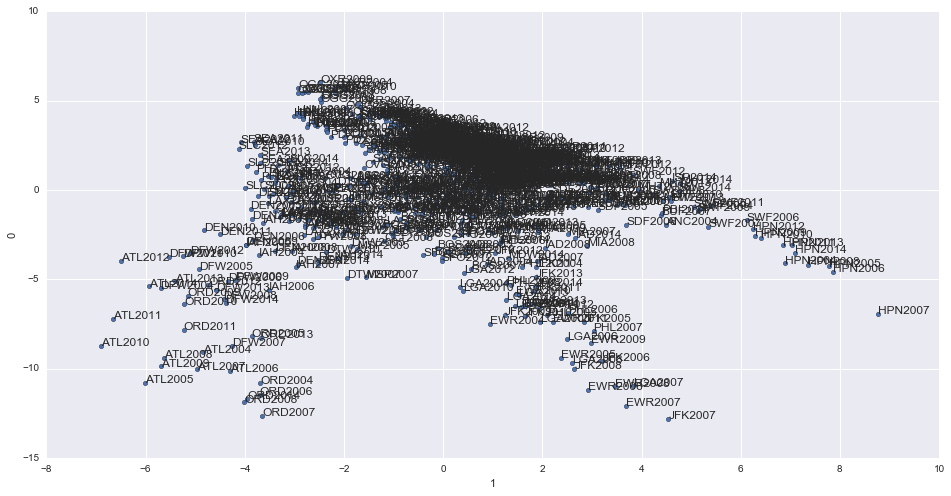

In [137]:
graph = pca_df.plot(kind='scatter', x=1, y=0, figsize=(16,8))

for i, airport in enumerate(pca_df['air_id']):
    graph.annotate(airport, (pca_df.iloc[i][1], pca_df.iloc[i][0]))

#### 5.9 Write an analysis plan of your findings

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps

We plotted the first two prinicpal components in a scatter plot, as seen above. If we were to continue with our analysis, the next step would be to build a model using the prinicpal components we identified in PCA (a total of twenty -- the plot above simply shows the relationship between two).

We identified that the first twenty components accounted for just 69% of the variance in our original feature space. This is a less than ideal finding (we would have preferred to see fewer components account for a larger percentage of the total variance). 

In deciding to use the first twenty principal components, we in effect are ignoring the variance accounted for by the remaining components that we didn't use. This remaining variance accounts for 31% of the total variance in the data.

If we continued our analyss and built a model, we'd use the principal components rather than the original features. The benefit of doing this would be to reduce the dimensionality of our data. Why would we want to reduce dimensionality? There are two primary reasons. First, it allows us to simplify the data. After dimensionality reduction, the lower-dimensional feature space represents a simplified feature space representing the directions that account for the most variance in the data. Second, dimensionality reduction allows for faster processing and is thus less computationally expensive.

A key drawback of PCA might be interpretability. It's one thing to say X feature has Y impact on our target. It's another thing to say X principal component has Y impact on our target. Thus, we sacrfice interpretability for a consolidated feature space and faster computation.

## Bonus:

#### 1. Conduct the analysis again using different variables from the airport_operations.csv dataset

#### 2. Create visualization of your data using the ggplot features of matplotlib